# Lecture 10 — Advanced topics I


Based on your exceptional participation in last class, I took your questions home and created this advanced topics class. It’s wonderful to see you actively participating in this class with more complex questions. 

Therefore, I decided to review most of your questions and also cover dimensionality reduction techniques. I hope you enjoy this class!


## Learning Outcomes
By the end of this lecture, you will be able to:

0. Have the answer for: Is sklearn really useful in real-world applications?
1. Understand K‑Fold Cross‑Validation (CV)
2. Be familiar with Learning Curves in sklearn
3. Understand and identify *Overfitting*: Model Capacity vs. Score
4. Know the difference between *dimensionality Reduction techniques*: **PCA vs t‑SNE** — practical explanations and uses
5. Perform hyperparameter tuning with **GridSearchCV** 
6. Linear decision trees

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import KFold, train_test_split, LearningCurveDisplay, GridSearchCV, cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.datasets import load_digits

# Reusable random state
rng = np.random.RandomState(42)


## 0) SKlearn in the industry

Is this used at all? Looks like it! Let's take a look in the link below!

https://scikit-learn.org/stable/testimonials/testimonials.html

**TLDR**:**SKlearn is widely used in real applications!**

However, big tech companies like Google and Microsoft also develop their own ML packages. Examples are [JAX](https://docs.jax.dev/en/latest/index.html), [TensorFlow](https://www.tensorflow.org), [LightGBM](https://lightgbm.readthedocs.io/en/stable/)

Back to our class... We use a toy dataset/function from previous lectures for regression demos.

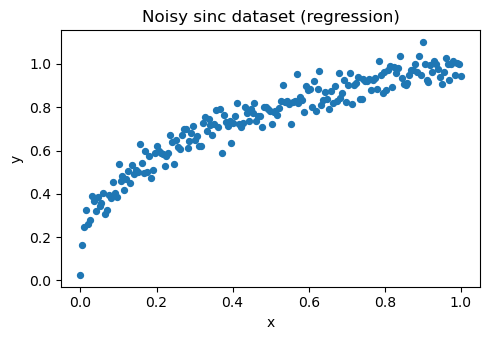

In [2]:
X = np.linspace(0, 1, 200).reshape(-1, 1)
y = X[:, 0]**(1/3) + rng.normal(0, 0.05, size=X.shape[0])

plt.figure(figsize=(5,3.5))
plt.scatter(X, y, s=18)
plt.title('Noisy sinc dataset (regression)')
plt.xlabel('x')
plt.ylabel('y')
plt.tight_layout()

## 1) Understand K‑Fold Cross‑Validation (CV)

Below we employ simple **KFold**. We'll plot which indices belong to **train** vs **test** in each fold for our regression dataset.

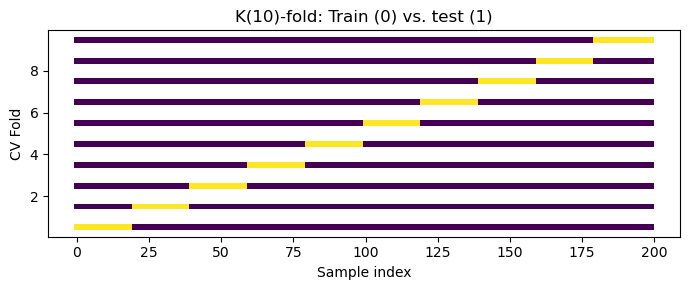

In [4]:
kf2 = KFold(n_splits= 10)

def plot_kfold_assignments(cv, n_samples):
    plt.figure(figsize=(7,3))

    for i , (tr, te) in enumerate(cv.split(np.arange(n_samples))):
        mask = np.full(n_samples, -1.0)
        mask[tr] = 0.0
        mask[te] = 1.0
        plt.scatter(range(n_samples), [i + 0.5]*n_samples, c=mask, marker='s', s=18, linewidths=0)
    
    plt.xlabel('Sample index')
    plt.ylabel('CV Fold')
    plt.title('K(10)-fold: Train (0) vs. test (1)')
    plt.tight_layout()
                                  

plot_kfold_assignments(kf2, n_samples=len(X))

In [5]:
reg = DecisionTreeRegressor(max_depth=5, random_state=42)
scores = cross_val_score(reg, X, y, cv=kf2, scoring='neg_root_mean_squared_error')
print('k-fold CV RMSE', -scores)
print('Mean RMSE', -scores.mean())

k-fold CV RMSE [0.2323499  0.09238678 0.03926587 0.07719534 0.07433862 0.05981049
 0.06512668 0.05900143 0.05520009 0.13297972]
Mean RMSE 0.08876549227198552


## 2) Learning Curves (with `LearningCurveDisplay`)

We plot training score and cross‑validation score vs. the number of training samples, for example, Let's use a `MLPRegressor` from the NN class example (Lecture 7). 


In [8]:
from sklearn.neural_network import MLPRegressor

reg = MLPRegressor(hidden_layer_sizes=(3,),
                   activation='tanh',
                   solver='lbfgs',
                   alpha=0.5,
                   max_iter=5000,
                   random_state=42




)

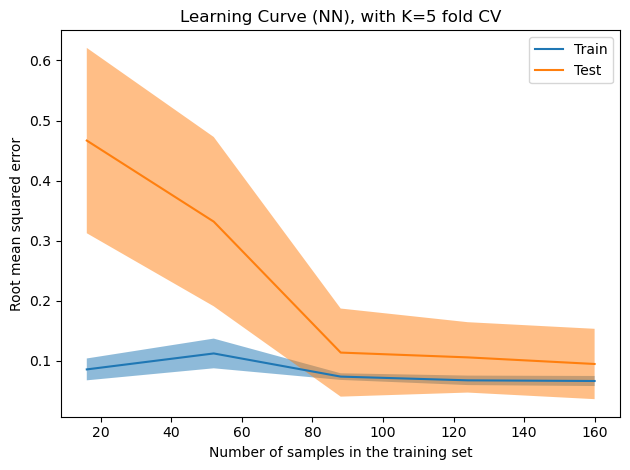

In [9]:
kf5 = KFold(n_splits=5)

disp = LearningCurveDisplay.from_estimator(reg,
                                           X,
                                           y,
                                           cv=kf5,
                                           scoring='neg_root_mean_squared_error',
                                           negate_score= True)

plt.title('Learning Curve (NN), with K=5 fold CV')
plt.tight_layout()

## 3) Overfitting: Capacity vs. RMSE


Overfitting is a common issue in ML. It occurs when the model works extremely well for the training dataset, but it does not generalize well when we do inference in the test/validation sets. Let's go straight to an example.

We increase **model capacity** via `max_depth` of the decision tree and track **training RMSE** and **validation RMSE**.  
To make the effect clear, we keep the dataset modest so deeper trees can overfit.


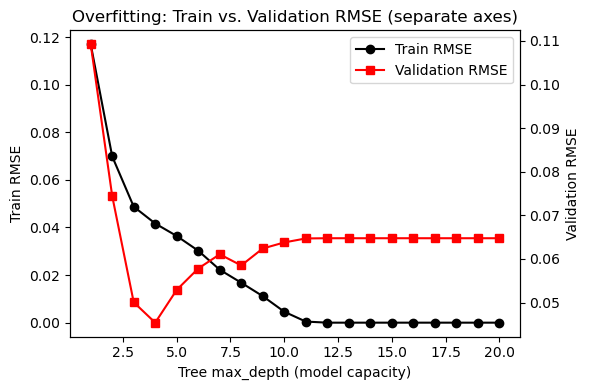

In [11]:
X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.2, random_state=42)

depths = list(range(1, 21))

rmse_train, rmse_val = [], []

for d in depths:
    reg = DecisionTreeRegressor(max_depth=d, random_state=0)
    reg.fit(X_tr, y_tr)
    yhat_tr = reg.predict(X_tr)
    yhat_te = reg.predict(X_te)
    rmse_train.append(np.sqrt(mean_squared_error(y_tr, yhat_tr)))
    rmse_val.append(np.sqrt(mean_squared_error(y_te, yhat_te)))

fig, ax1 = plt.subplots(figsize =(6,4))

ax2 = ax1.twinx()
ax1.plot(depths, rmse_train, marker='o', c='k', label= 'Train RMSE')
ax2.plot(depths, rmse_val, marker='s', c='r', label='Validation RMSE')

ax1.set_xlabel('Tree max_depth (model capacity)')
ax1.set_ylabel('Train RMSE')
ax2.set_ylabel('Validation RMSE')
ax1.set_title('Overfitting: Train vs. Validation RMSE (separate axes)')


lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()

ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper right')
plt.tight_layout()

You can see from the red curve that after a certain value of the `max_depth`, the RMSE actually gets worse, despite the training RMSE decreases! Looking only at the train score can be misleading!

## 4) Dimensionality Reduction: **PCA vs t‑SNE**

We focus on **representation** (not clustering). Both methods map high dimensional data to low dimensions, for visualization purposes. It is beyond the scope of this class to go over all mathematical details of PCA and t-SNE, but I think it's a good idea to introduce the topic to you all.

### PCA — Principal Component Analysis (linear)
- Finds orthogonal directions (**principal components**) that **maximize variance**.
- Math (sketch): center data $X\in\mathbb{R}^{n\times d}$, compute covariance $\Sigma = \tfrac{1}{n} X^\top X$
  PCs are **eigenvectors** of $\Sigma$ with eigenvalues giving explained variance
- Properties: linear, fast, global; components are linear combinations of original features

### t‑SNE — t‑Distributed Stochastic Neighbor Embedding (nonlinear)
- Builds **probability distributions** over pairs of points so that **nearby points** have high probability in high dimensions and (in the map/embedding) in low dimensions.
- Properties: emphasizes **local "neighborhoods"**; distances **between far groups** are *not* meaningful; sensitive to random seed.

**Again:** Neither PCA nor t‑SNE is a classifier or a clustering algorithm. They are dimensionality reduction techniques.


Trivia: t-SNE was created by the same guy who did fundamental and groundbreaking work in neural networks, Geofrrey Hinton, which was a CMU faculty. [Here's the link to t-sne paper.](https://www.jmlr.org/papers/volume9/vandermaaten08a/vandermaaten08a.pdf)

Here, we use the famous [digits dataset](https://scikit-learn.org/1.5/auto_examples/datasets/plot_digits_last_image.html).


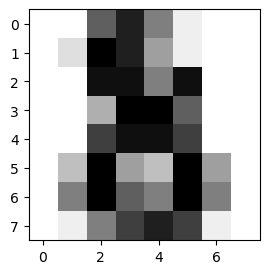

In [13]:
# Example: Digits data 
digits = load_digits()
Xd = digits.data
yd = digits.target

# Display the last digit (# Code source: Gaël Varoquaux) 
# Modified for documentation by Jaques Grobler
# License: BSD 3 clause
# https://scikit-learn.org/1.5/auto_examples/datasets/plot_digits_last_image.html
plt.figure(1, figsize=(3, 3))
plt.imshow(digits.images[-1], cmap=plt.cm.gray_r, interpolation="nearest")
plt.show()

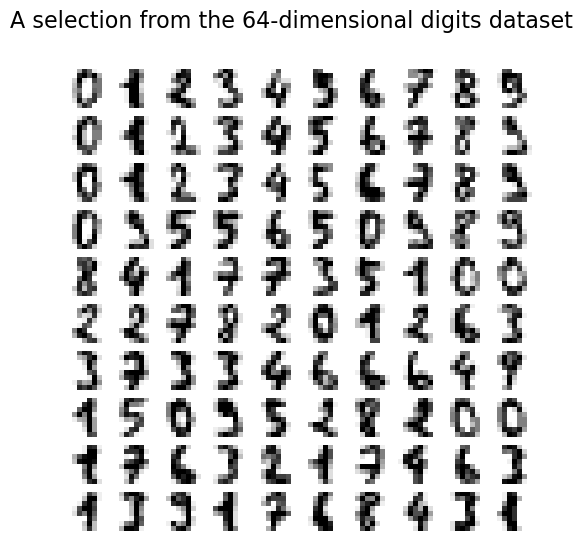

In [14]:

# Authors: The scikit-learn developers
# SPDX-License-Identifier: BSD-3-Clause
fig, axs = plt.subplots(nrows=10, ncols=10, figsize=(6, 6))
for idx, ax in enumerate(axs.ravel()):
    ax.imshow(Xd[idx].reshape((8, 8)), cmap=plt.cm.binary)
    ax.axis("off")
_ = fig.suptitle("A selection from the 64-dimensional digits dataset", fontsize=16)

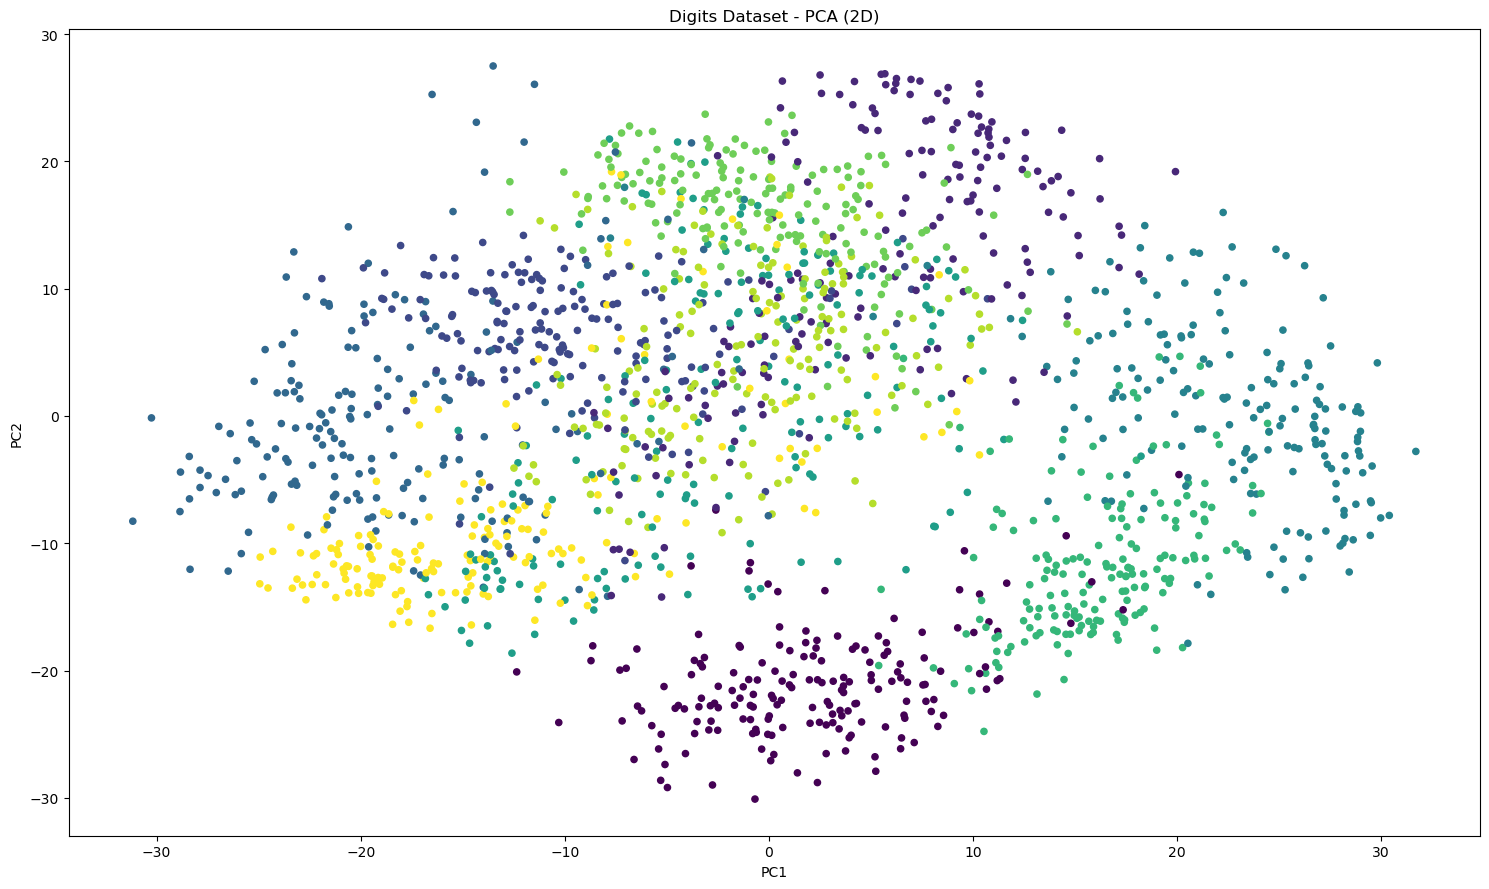

In [18]:
# PCA (2D)

pca = PCA(n_components = 4 , random_state=0)
Xd_pca = pca.fit_transform(Xd)

plt.figure(figsize=(15, 9))
plt.scatter(Xd_pca[:, 0], Xd_pca[:,1], c = yd, s=20)
plt.title('Digits Dataset - PCA (2D)')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.tight_layout()

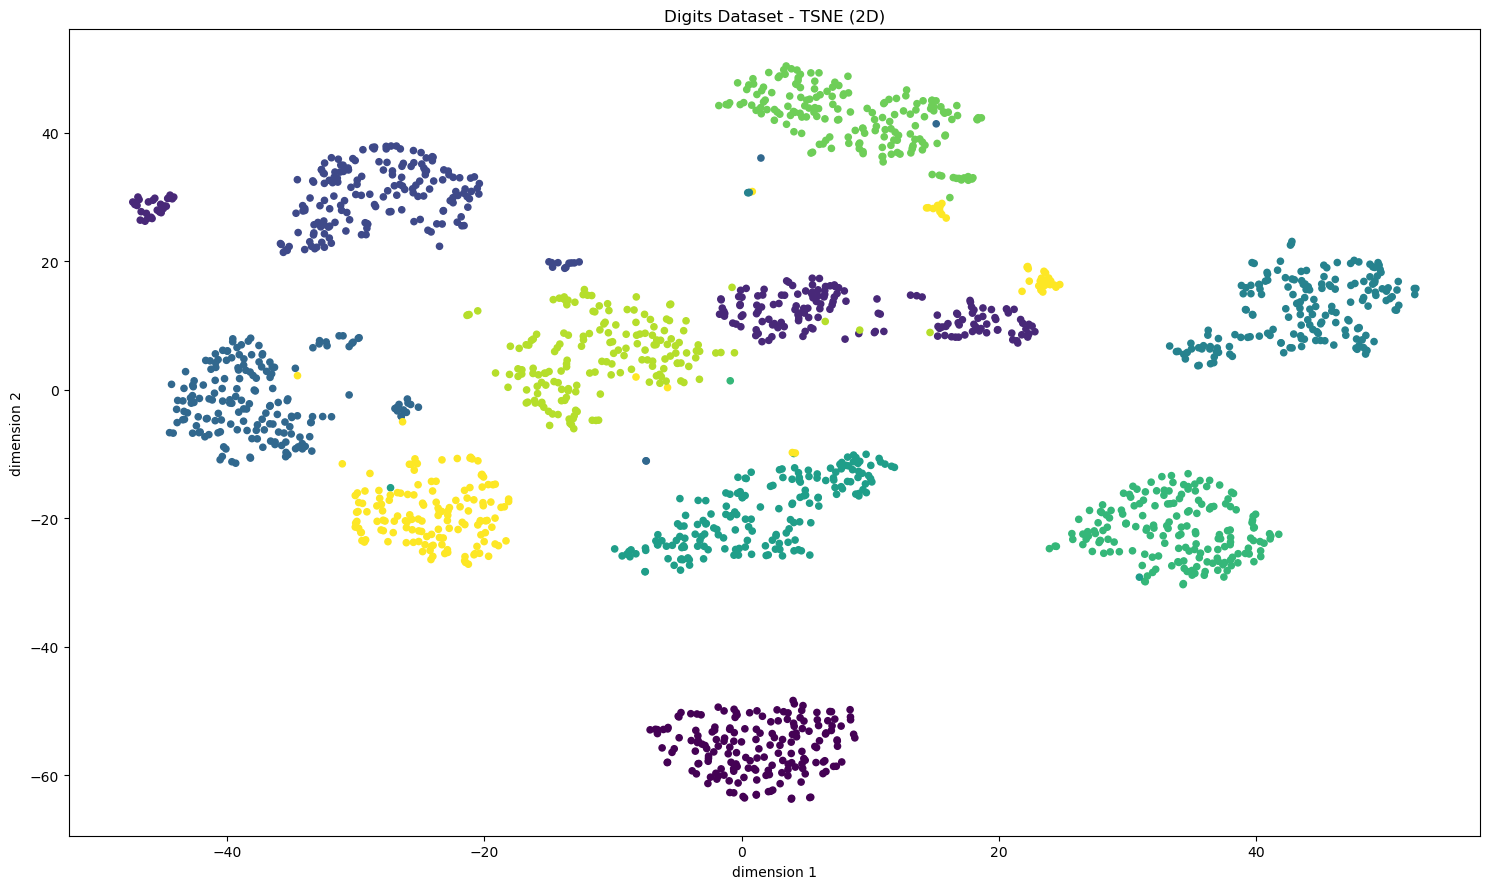

In [20]:
tsne = TSNE(n_components=2, init='pca', learning_rate='auto', perplexity=30, random_state=0)

Xd_tsne = tsne.fit_transform(Xd)
plt.figure(figsize=(15, 9))
plt.scatter(Xd_tsne[:, 0], Xd_tsne[:,1], c = yd, s=20)
plt.title('Digits Dataset - TSNE (2D)')
plt.xlabel('dimension 1')
plt.ylabel('dimension 2')
plt.tight_layout()


Some interesting stuff on PCA and T-SNE:

- [Principal Component Analysis, explained visually](https://setosa.io/ev/principal-component-analysis/)

- [A Visual and Overly Simplified Guide to PCA](https://blog.dailydoseofds.com/p/a-visual-and-overly-simplified-guide)

- [Interactive publication on t-sne by Google researchers](https://distill.pub/2016/misread-tsne/)

Ok, but what now?

- **Color encodes the ground‑truth digit** (only for interpretation).
- **PCA**: linear projection; some digits overlap because the underlying separation is nonlinear.
- **t‑SNE**: same digits tend to form **"islands"**.

Practical tips:
- Start with **PCA**: It's quick, and has linear structure; inspect explained variance to choose dimensions.
- Use **t‑SNE** for local manifold structure; try a few **perplexity** values (e.g., 5–50). Fix `random_state` for reproducibility.


### PCA vs t‑SNE — key differences
| Aspect | PCA | t‑SNE |
|---|---|---|
| Type | Linear projection | Nonlinear embedding |
| Preserves | Global variance directions | Local neighborhoods |
| Distances between far groups | Meaningful (linear) | Not meaningful |
| Speed / scale | Fast, scalable | Slower; tune `perplexity` |
| Main knobs | `n_components` | `perplexity`, `learning_rate`, initialization |
| Use cases | Compression, denoising, quick structure check | Visualizing clusters/manifolds; exploratory analysis |

## 5) Hyperparameter Tuning with `GridSearchCV`

This was another question from previous class: "Can we do better when coming up with the selection of the hyperparameters".

Yup! Let's see an example. 

We tune a **DecisionTreeRegressor** on our toy dataset, searching over `max_depth` and `min_samples_leaf` using **KFold** CV.


In [21]:
param_grid = {

    'max_depth': [2, 3, 4, 5, 6],
    'min_samples_leaf': [1, 2, 4, 8]


}

base = DecisionTreeRegressor(random_state=0)

cv = KFold(n_splits=5)

gcv = GridSearchCV(base, param_grid, cv = cv, scoring = 'neg_root_mean_squared_error')
gcv.fit(X, y)

print('Best parameters:', gcv.best_params_)
print('Best CV RMSE:', -gcv.best_score_)


Best parameters: {'max_depth': 4, 'min_samples_leaf': 2}
Best CV RMSE: 0.09441459329669424


## 6) Linear decision trees

It turns out that when working with tree, the decision on/when to split doesn't have to be necessarily a constant value (standard decision trees). They can be linear relationships, which brings enormous flexibility to ML regression models.

Linear decision trees are not natively available in SKLearn, but there is a package called [linear-tree](https://github.com/cerlymarco/linear-tree) based on Sklearn that allows the ML modeling of linear decision trees.

In our department, prof. Laird and his PhD students work quite extensively with linear decision trees, embedding them in optimization problems. A package called [OMLT - Optimization and Machine Learning Toolkit](https://github.com/cog-imperial/OMLT) developed together with collaborators from the Imperial College allows to "translate" these ML trees into an optimization modeling language called [Pyomo](https://www.pyomo.org).

Why is this useful?

- We bridge ML and Optimization theory together. We can express optimization problems with ML models/surrogates!
- Let's take a look at [this paper](https://www.sciencedirect.com/science/article/pii/S009813542300217X) from one of Prof. Laird's students
- These problems can be represented as mixed-integer programming problems. You'll see more details on the next mini class!


## Summary
- **KFold** cross validation CV is a powerful tool to perform model selection.
- **Learning curves** can show the effect of training dataset size.
- **Overfitting** can be identified, among several possible tests, as *low training RMSE* but *rising validation RMSE* as model capacity increases.
- **PCA vs t‑SNE**: linear global variance vs nonlinear local neighborhoods; choose based on your goal.
- **GridSearchCV** wraps CV to select hyperparameters using your familiar models from previous classes!
